In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

In [2]:
PowerList = [25,50,100,250,500,1000,1500,2000] # Electrolyser power in kW
BatteryList = [0,50,100,500,1000,2000,4000] # Battery capacities in kWh
ColourPallet = ['k','#E69F00','#56B4E9','#009E73','#0072B2','#D55E00','#CC79A7','#4B0092']

In [3]:
Const = pd.read_csv('../Data/Analysis/Const/Const.csv',
                    index_col=['Parameter'])
P_wtLim = (Const.loc['P_wtmaxE44'].values[0]+Const.loc['P_wtmaxE53'].values[0])/1e3 # Conversion to MW of two wind turbines
P_pvLim1 = (Const.loc['P_pvLim1'].values[0])/1e3 # Conversion to MW of solar panels, assuming greatest limit (pre-August 4.4 MW)
P_pvLim2 = (Const.loc['P_pvLim2'].values[0])/1e3 # Conversion to MW of solar panels, assuming greatest limit (post-August 3.5 MW)

In [ ]:
def PlotHydrogenSimulation(folder_path,Values,fig_name,colours,cumulative=True,units='kW',title=None,
                           log=False,by_size=False,save_fig=False,capacity=None,DateRanges=None):
    """
    Function for plotting hydrogen simulations

    Parameters
    ----------
    folder_path : str
        Where simulation outputs are stored.
    Values : List
        A list of floats which have been explored.
    fig_name : str
        Name under which the figure will be saved.
    colours : List
        List of colours for colour pallet.
    cumulative : boolean
        If True, a cumulative plot will be generated for the hydrogen production plot.
        If False, a monthly total will be shown.
        Defaults to True.
    units : str
        Units of input values being explored.
        Defaults to 'kW'.
    title : str
        Title given to plot (only on png outputs).
    log : boolean
        If True, a logarithmic y-axis will be used for the hydrogen production plot.
        If False, a linear y-axis will be used.
        Defaults to False.
    by_size : boolean
        If True, a DataFrame is produced scaled by size of input (e.g. electrolyser size)
        If False, no such DataFrame is created.
        Defaults to False
    save_fig : boolean
        If True, the figures are saved. 
        If False, the figures are not saved.
    capacity : List
        Relevant power capacities (str).
        Defaults to None.
    DateRanges : List
        Dates corresponding to power capacities (str)
        Correspond to end of period capacity applies to.
        Leave empty if there is only one capacity value.
        Defaults to None.
    """
    data1 = pd.DataFrame()
    data2 = pd.DataFrame()
    data3 = pd.DataFrame()
    
    fig, ax1 = plt.subplots()

    ax1.set_xlim(pd.Timestamp('2023-01-01'), pd.Timestamp('2023-12-31'))

    for i, value in enumerate(Values):
        current_df_initial = pd.read_csv(f'{folder_path}/{value}.csv',
                        parse_dates=['DateTime'],
                        index_col=['DateTime']).astype(float)
        if cumulative is True:
            current_df = current_df_initial.cumsum()
            ax1.set_ylabel('Cumulative Green Hydrogen Produced [t]')
        else:
            current_df = (current_df.resample('ME').sum()).to_period('M').to_timestamp()
            ax1.set_ylabel('Green Hydrogen Produced [t]')

        ax1.plot(current_df['Hydrogen']/1e3, label = f"{str(value)} {units}", linewidth = 2, color = colours[i])

        data1.loc[f'{value}',f'{fig_name}'] = (current_df_initial.cumsum()).loc[pd.Timestamp('2023-12-01'),'Hydrogen']/1e3

        if by_size is True:
            data3.loc[f'{value}',f'{fig_name}'] = data1.loc[f'{value}',f'{fig_name}']/(value/1e3) # units to MW
        else:
            data3.loc[f'{value}',f'{fig_name}'] = None

        if capacity is not None:
            if DateRanges is not None:
                H_per_MW = 0
                for i in range(len(capacity)):
                    H_per_MW = ((current_df_initial.cumsum()).loc[pd.Timestamp(DateRanges[i]),'Hydrogen'])/capacity[i] + H_per_MW
            else:
                H_per_MW = ((current_df_initial.cumsum()).loc[pd.Timestamp('2023-12-01'),'Hydrogen'])/capacity
            
            data2.loc[f'{value}',f'{fig_name}'] = H_per_MW/1e3
        else:
            data2.loc[f'{value}',f'{fig_name}'] = None
    #Make all the months show up
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%B')) # Month and year on x-axis
    ax1.xaxis.set_major_locator(mdates.MonthLocator()) # Each month shown

    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

    # formatting axes
    ax1.set_xticks(pd.date_range(start='2023-01-01', end='2023-12-31', freq='MS')) 
    ax1.set_xlabel('Time')

    ax1.legend()

    if log is True:
        ax1.set_yscale('log')
    
    ax1.set_xlim(pd.Timestamp('2023-01-01'), pd.Timestamp('2023-12-01'))
    ax1.set_ylim(bottom=0)
    ax1.tick_params(axis='both', direction='in',labelleft=True,labelright=True,left=True,right=True)

    fig.tight_layout()
    
    if save_fig is True:
        fig.savefig(f'../Figures/pdf/{fig_name}_Production.pdf')
        ax1.set_title(title)
        fig.tight_layout()
        fig.savefig(f'../Figures/png/{fig_name}_Production.png')

    ### Electrolyser Activity Plots ###
    fig, ax1 = plt.subplots()

    for i, value in enumerate(Values):
        current_df_initial = pd.read_csv(f'{folder_path}/{value}.csv',
                        parse_dates=['DateTime'],
                        index_col=['DateTime']).astype(float)

        current_df_initial['row'] = 1

        current_df_monthly = current_df_initial.resample('ME').sum().to_period('M').to_timestamp()
        current_df_monthly['beta_frac'] = current_df_monthly['beta'].divide(current_df_monthly['row'])

        ax1.plot(current_df_monthly['beta_frac'], label = f"{str(value)} {units}", linewidth = 2, color = colours[i])

    #Make all the months show up
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%B')) # Month and year on x-axis
    ax1.xaxis.set_major_locator(mdates.MonthLocator()) # Each month shown

    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

    # formatting axes
    ax1.set_xticks(pd.date_range(start='2023-01-01', end='2023-12-31', freq='MS')) 
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Monthly Fractional Activity of Electrolyser')
    
    ax1.set_xlim(pd.Timestamp('2023-01-01'), pd.Timestamp('2023-12-01'))
    ax1.set_ylim(0,1)
    ax1.tick_params(axis='both', direction='in',labelleft=True,labelright=True,left=True,right=True)

    fig.tight_layout()
    
    if save_fig is True:
        fig.savefig(f'../Figures/pdf/{fig_name}_Activity.pdf')
        ax1.set_title(title)
        fig.tight_layout()
        fig.savefig(f'../Figures/png/{fig_name}_Activity.png')

    return [data1,data2,data3]

In [5]:
def SaveHydrogenSimulation(DataFrames,col_names,index_name_csv,index_name_tex,file_name,formats,**kwargs):
    """
    Function for saving hydrogen simulation data

    Parameters
    ----------
    DataFrames : List
        A list of relevant DataFrames (pd.DataFrame)
    col_names : List
        A list of column names (str).
    index_name_csv : str
        Name to be assigned to the index (in the csv file).
    index_name_tex : List
        Name to be assigned to the index (in the LaTeX file).
        Two strings (the name followed by the units).
    file_name : str
        Name under which the data will be saved.
    formats : List
        List of formats of each column in the output csv and LaTeX files.
    **kwargs : any
        Key word arguments for formatting the LaTeX table.
    """
    df = pd.DataFrame()
    for i in range(len(DataFrames)):
        if DataFrames[i][1].iloc[0,0] is None:
            df = pd.concat([df,DataFrames[i][0]],axis=1)
        else:
            df = pd.concat([df,DataFrames[i][0],DataFrames[i][1]],axis=1)
        if DataFrames[i][2].iloc[0,0] is not None:
            df = pd.concat([df,DataFrames[i][2]],axis=1)

    df.columns = df.columns.get_level_values(0)
    df.index.name = None

    ## Saving to csv ##
    updated_cols = []
    df_csv = df.copy()
    for i in range(len(col_names)):
        if i == 0:
            updated_cols.append((col_names[i],'H2 Mass [t]'))
            if DataFrames[i][2].iloc[0,0] is not None:
                updated_cols.append((col_names[i],'H2 Mass by Electrolyser Size [t/MW]'))
        else:
            updated_cols.append((col_names[i],'H2 Mass [t]'))
            updated_cols.append((col_names[i],'H2 Mass by Capacity [t/MW]'))

            if DataFrames[i][2].iloc[0,0] is not None:
                updated_cols.append((col_names[i],'H2 Mass by Electrolyser Size [t/MW]'))
            
    df_csv.columns = pd.MultiIndex.from_tuples(updated_cols,names=('Power Source:',index_name_csv))

    for i in range(df_csv.shape[1]):
        df_csv[df_csv.columns[i]] = df_csv[df_csv.columns[i]].apply(f'{formats[i]}'.format)
    
    df_csv.to_csv(f'../Data/Analysis/Data_Tables/csv/{file_name}.csv',
              index=True)

    ## Saving to LaTeX ##
    updated_cols = []
    df_tex = df.copy()
    for i in range(len(col_names)):
        if i == 0:
            updated_cols.append((col_names[i],r'$M_{\mathrm{H2}}$',r'$\left[\mathrm{t}\right]$'))
            if DataFrames[i][2].iloc[0,0] is not None:
                updated_cols.append((col_names[i],r'$M_{\mathrm{H2}}/P_{\mathrm{el,max}}$',r'$\left[\mathrm{t/MW}\right]$'))
        else:
            updated_cols.append((col_names[i],r'$M_{\mathrm{H2}}$',r'$\left[\mathrm{t}\right]$'))
            updated_cols.append((col_names[i],r'$M_{\mathrm{H2}}/P_{\mathrm{cap}}$',r'$\left[\mathrm{t/MW}\right]$'))
            if DataFrames[i][2].iloc[0,0] is not None:
                updated_cols.append((col_names[i],r'$M_{\mathrm{H2}}/P_{\mathrm{el,max}}$',r'$\left[\mathrm{t/MW}\right]$'))
            
    df_tex.columns = pd.MultiIndex.from_tuples(updated_cols,names=('Power Source:',index_name_tex[0],index_name_tex[1]))

    for i in range(df_tex.shape[1]):
        df_tex[df_tex.columns[i]] = df_tex[df_tex.columns[i]].apply(f'{formats[i]}'.format)

    if DataFrames[0][2].iloc[0,0] is not None:
        column_format = 'l|cc|ccc|ccc'
    else:
        column_format = 'l|c|cc|cc'

    df_tex.to_latex(f'../Data/Analysis/Data_Tables/tex/{file_name}.tex',
                multicolumn=True,multicolumn_format='|c',index=True,
                column_format=column_format,**kwargs)

# Varying the Electrolyser

## With a Battery

### Using power excess

#### A plot of green hydrogen produced by time for varying electrolyser sizes, assuming a battery of size $2\ \mathrm{MWh}$ and use of power excess.

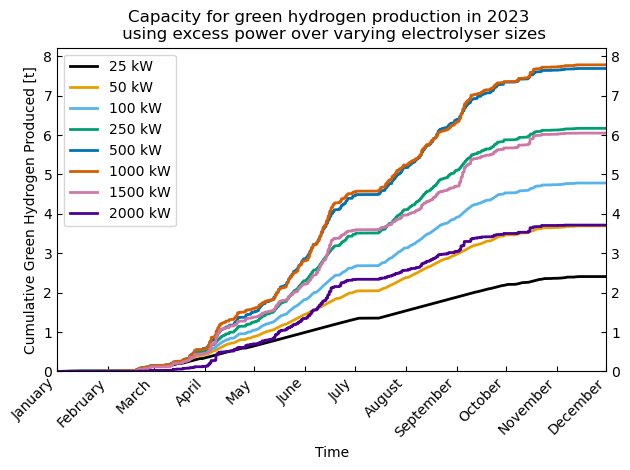

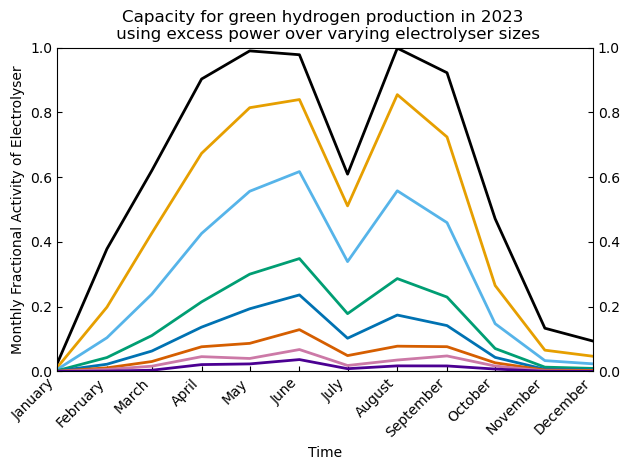

In [6]:
H_Sim_VaryElectrolyser_PowerExcess = PlotHydrogenSimulation('../Data/Analysis/Simulations/Electrolyser/Battery/Excess',
                                                            PowerList,'H_Sim_VaryElectrolyser_PowerExcess',
                                                            ColourPallet,True,title='Capacity for green hydrogen production in 2023 \n using excess power over varying electrolyser sizes',
                                                            by_size=True)

### Using only solar power

#### A plot of green hydrogen produced by time for varying electrolyser sizes, assuming a battery of size $2\ \mathrm{MWh}$ and use of only solar power production.

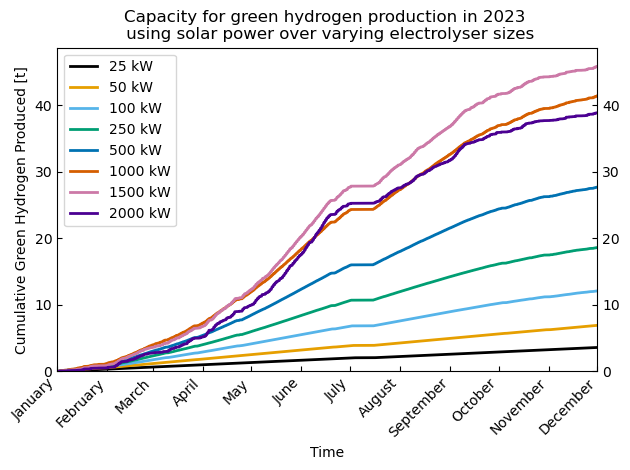

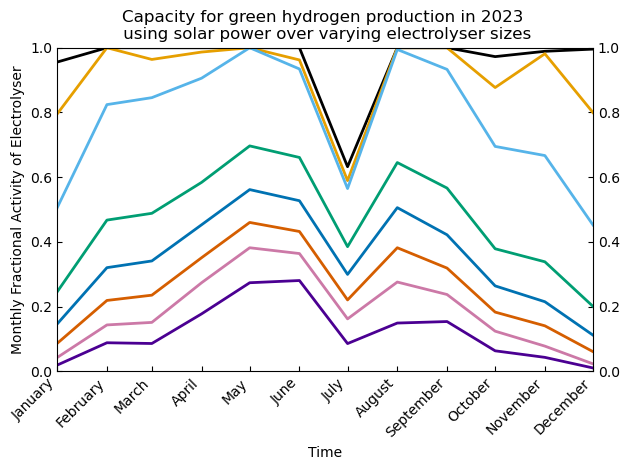

In [7]:
H_Sim_VaryElectrolyser_Solar = PlotHydrogenSimulation('../Data/Analysis/Simulations/Electrolyser/Battery/Solar',
                                                      PowerList,'H_Sim_VaryElectrolyser_Solar',
                                                      ColourPallet,True,
                                                      title='Capacity for green hydrogen production in 2023 \n using solar power over varying electrolyser sizes',
                                                      capacity=[P_pvLim1,P_pvLim2],DateRanges=['2023-08-17','2023-12-31 23:55:00'],
                                                      by_size=True)

### Using only wind power

#### A plot of green hydrogen produced by time for varying electrolyser sizes, assuming a battery of size $2\ \mathrm{MWh}$ and use of only wind power production.

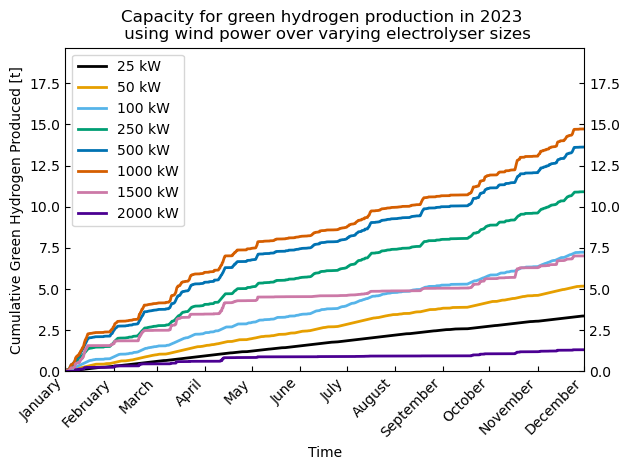

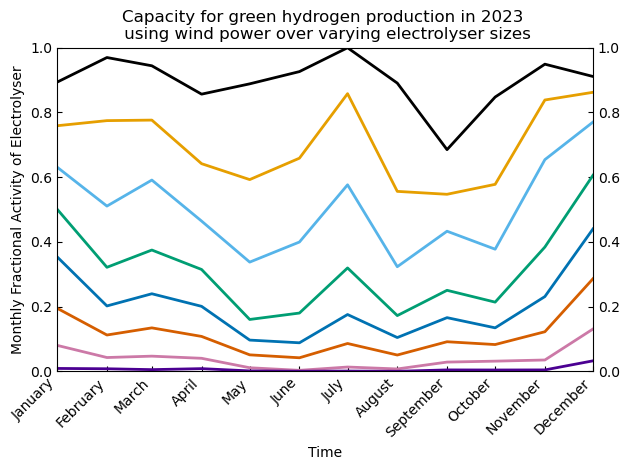

In [8]:
H_Sim_VaryElectrolyser_Wind = PlotHydrogenSimulation('../Data/Analysis/Simulations/Electrolyser/Battery/Wind',PowerList,
                                                     'H_Sim_VaryElectrolyser_Wind',
                                                     ColourPallet,True,
                                                     title='Capacity for green hydrogen production in 2023 \n using wind power over varying electrolyser sizes',
                                                     capacity=P_wtLim,
                                                     by_size=True)

### Generating a Table
**Caption:** Simulated total green hydrogen produced [t] over 2023 for different electrolyser sizes [kW].

In [9]:
formats = ['{:.3g}','{:.3g}','{:.3g}','{:.3g}','{:.3g}','{:.3g}','{:.3g}','{:.3g}','{:.3g}','{:.3g}']

df = SaveHydrogenSimulation([H_Sim_VaryElectrolyser_PowerExcess,
                        H_Sim_VaryElectrolyser_Solar,
                        H_Sim_VaryElectrolyser_Wind],
                        ['Power Excess', 'Solar','Wind'],
                        'Electrolyser Power [kW]',
                        [r'$P_{\mathrm{el,max}}$',r'$\left[\mathrm{kW}\right]$'],
                        'VaryElectrolyser',
                        formats=formats,
                        label='tab: VaryElectrolyser',
                        )

# Varying the Battery

### Using power excess

#### A plot of green hydrogen produced by time for varying battery sizes, assuming an electrolyser of size $25\ \mathrm{kW}$ and use of excess power production.

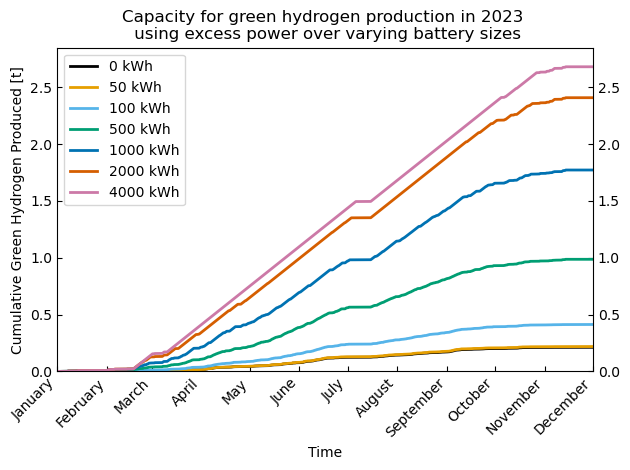

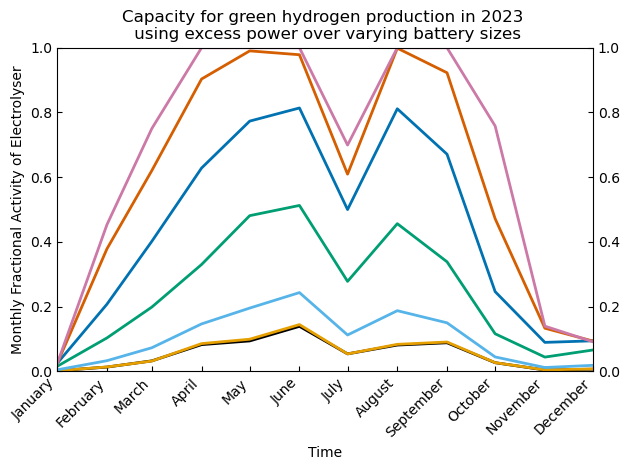

In [10]:
H_Sim_VaryBatt_PowerExcess = PlotHydrogenSimulation('../Data/Analysis/Simulations/Battery/Excess',BatteryList,
                                                            'H_Sim_VaryBattery_PowerExcess',ColourPallet,True,'kWh',
                                                            title='Capacity for green hydrogen production in 2023 \n using excess power over varying battery sizes')

### Using only solar power

#### A plot of green hydrogen produced by time for varying battery sizes, assuming an electrolyser of size $25\ \mathrm{kW}$ and use of only solar power production.

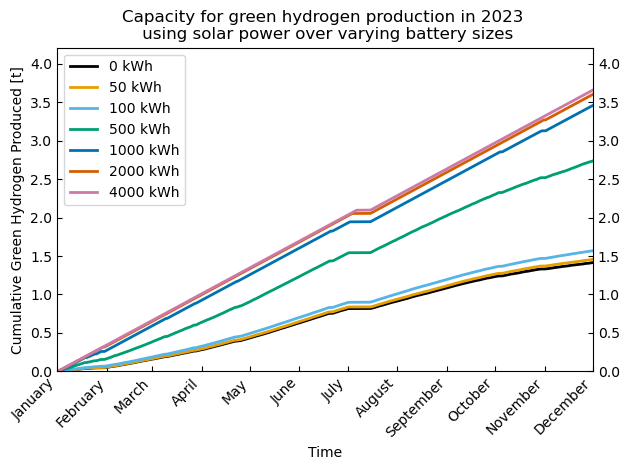

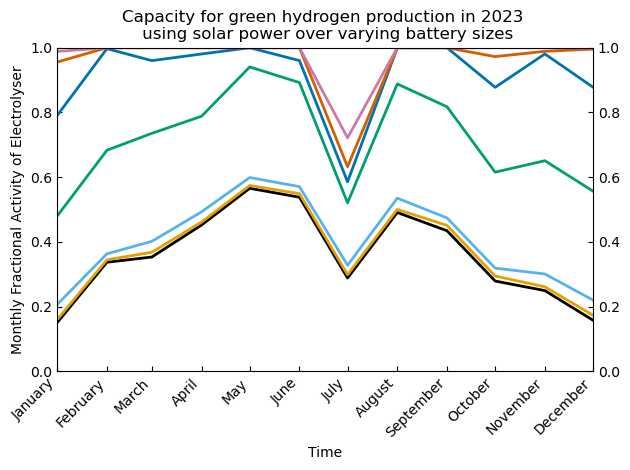

In [11]:
H_Sim_VaryBatt_Solar = PlotHydrogenSimulation('../Data/Analysis/Simulations/Battery/Solar',BatteryList,
                                                      'H_Sim_VaryBattery_Solar',ColourPallet,True,'kWh',
                                                      title='Capacity for green hydrogen production in 2023 \n using solar power over varying battery sizes',
                                             capacity=[P_pvLim1,P_pvLim2],DateRanges=['2023-08-17','2023-12-31 23:55:00'])

### Using only wind power

#### A plot of green hydrogen produced by time for varying battery sizes, assuming an electrolyser of size $25\ \mathrm{kW}$ and use of only wind power production.

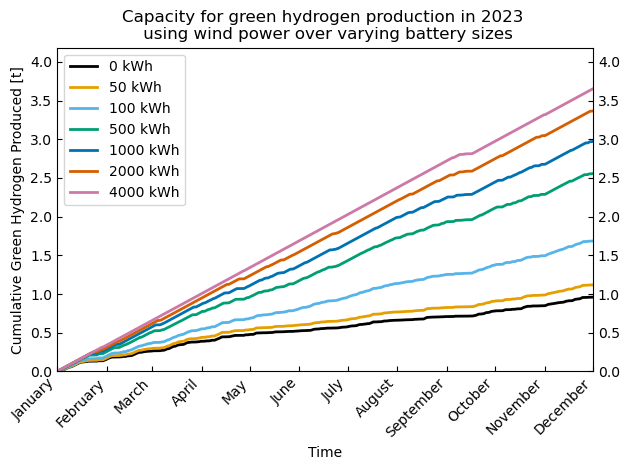

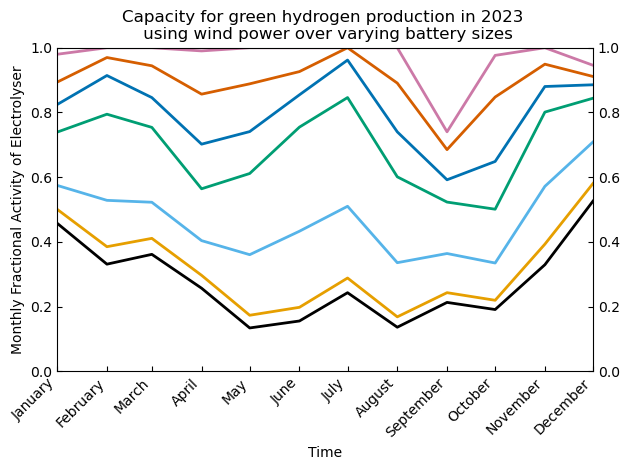

In [12]:
H_Sim_VaryBatt_Wind = PlotHydrogenSimulation('../Data/Analysis/Simulations/Battery/Wind',BatteryList,
                                                     'H_Sim_VaryBattery_Wind',ColourPallet,True,'kWh',
                                                     title='Capacity for green hydrogen production in 2023 \n using wind power over varying battery sizes',
                                            capacity=P_wtLim)

### Generating a Table
**Caption**: Simulated total green hydrogen produced [t] over 2023 for different battery capacities [kWh].

In [13]:
formats = ['{:.3g}','{:.3g}','{:.3g}','{:.3g}','{:.3g}','{:.3g}','{:.3g}']

SaveHydrogenSimulation([H_Sim_VaryBatt_PowerExcess,
                        H_Sim_VaryBatt_Solar,
                        H_Sim_VaryBatt_Wind],
                        ['Power Excess', 'Solar','Wind'],
                        'Battery Capacity [kWh]',
                        [r'$P_{\mathrm{batt,cap}}$',r'$\left[\mathrm{kWh}\right]$'],
                        'VaryBattery',
                        formats=formats,
                        label='tab: VaryBattery'
                        )